# One-shot one-step LSTM Model on Lab p4581
Author: Camilla Billari <br> 
Date: 19/01/24

Fitting a one-shot one-step LSTM to the Marone p4581 experiment.

In [2]:
# Import relevant libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import local_paths

# Change local path
sys.path.append(local_paths.MAIN_DIRECTORY)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

In [3]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(
        f"Total GPUs available: {torch.cuda.device_count()}"
    )  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.")

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

No GPU available.


## Load Data

In [4]:
# Access experiment and output dataframe head using Pritt's data loaders (which utilises Adriano's loading + pre-processing)
EXP = "p4581"
dataset = SlowEarthquakeDataset([EXP])
dataset.load()

# Extract optupts (X, Y, t)
ds_exp = dataset[EXP]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Create dataframe from outputs
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

print("N samples: {}".format(len(df)))
df.head()

N samples: 200010


,det_shear_stress,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,0.002811,1.29911,2.99288,NaN,NaN,0.000
1,0.002731,1.29903,2.99008,NaN,NaN,0.001
2,0.002231,1.29853,2.98854,NaN,NaN,0.002
3,0.002411,1.29871,2.98849,NaN,NaN,0.003
4,0.002241,1.29854,2.99069,NaN,NaN,0.004


In [5]:
df = df.dropna(axis=1)

## Data Pre-processing

### Downsampling

In [6]:
ds_factor = 1e2

downsampled_df = (
    df.rolling(window=int(ds_factor), step=int(ds_factor)).mean().dropna()
)
downsampled_df = downsampled_df.reset_index(drop=True)
downsampled_df = downsampled_df.dropna()
print("N downsampled samples: {}".format(len(downsampled_df)))
downsampled_df.head()

N downsampled samples: 2000


,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.003316,1.299621,2.989553,0.050500
1,0.005091,1.301409,2.989707,0.150501
2,0.006774,1.303105,2.989653,0.250501
3,0.008249,1.304593,2.989767,0.350502
4,0.009786,1.306144,2.989687,0.450502


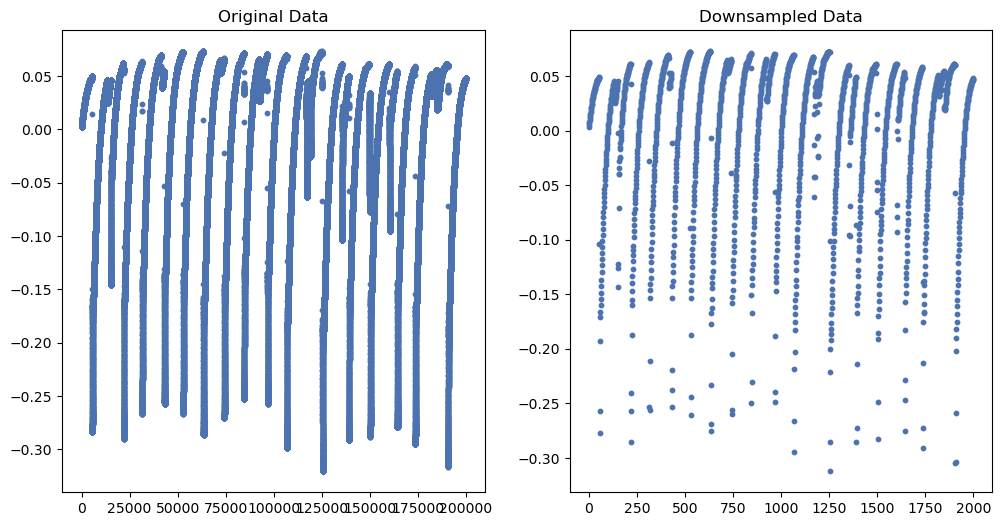

In [7]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.scatter(
    range(len(df)), df["det_shear_stress"], label="Original Data", s=10
)
# plt.plot(df["det_shear_stress"])
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(
    range(len(downsampled_df)),
    downsampled_df["det_shear_stress"],
    label="Downsampled Data",
    s=10,
)
# plt.plot(downsampled_df["det_shear_stress"])
plt.title("Downsampled Data")

plt.show()

In [8]:
# Display summary statistics for relevant features
print("Original Data Statistics:")
print(df["det_shear_stress"].describe())

print("\nDownsampled Data Statistics:")
print(downsampled_df["det_shear_stress"].describe())

Original Data Statistics:
count    2.000100e+05
mean    -1.414762e-15
std      7.344502e-02
min     -3.206090e-01
25%     -2.944483e-02
50%      2.964516e-02
75%      5.156659e-02
max      7.332104e-02
Name: det_shear_stress, dtype: float64

Downsampled Data Statistics:
count    2000.000000
mean       -0.000002
std         0.072732
min        -0.312222
25%        -0.030101
50%         0.029184
75%         0.051253
max         0.072780
Name: det_shear_stress, dtype: float64


In [9]:
from scipy.stats import f_oneway, ttest_ind

# Assuming you want to compare the mean and variance of a specific feature (e.g., "det_shear_stress")
original_feature = df["det_shear_stress"]
downsampled_feature = downsampled_df["det_shear_stress"]

# Perform two-sample t-test for mean comparison
t_statistic_mean, p_value_mean = ttest_ind(
    original_feature, downsampled_feature
)

# Perform F-test for variance comparison
f_statistic, p_value_variance = f_oneway(original_feature, downsampled_feature)

# Print results for mean comparison
print("Mean Comparison:")
print("t-statistic:", t_statistic_mean)
print("p-value:", p_value_mean)

# Print results for variance comparison
print("\nVariance Comparison:")
print("F-statistic:", f_statistic)
print("p-value:", p_value_variance)

# Check if the p-values are below a significance level (e.g., 0.05)
if p_value_mean < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("There is no significant difference in means.")

if p_value_variance < 0.05:
    print("The difference in variances is statistically significant.")
else:
    print("There is no significant difference in variances.")

Mean Comparison:
t-statistic: 0.0013198680651895299
p-value: 0.9989468992575414

Variance Comparison:
F-statistic: 1.7420517094931367e-06
p-value: 0.9989469004472398
There is no significant difference in means.
There is no significant difference in variances.


## Creating the datastet

In [10]:
# Extract time series data
timeseries = downsampled_df["det_shear_stress"]

# Define train-test split proportions
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size

# Perform train-test split
train, test = timeseries[:train_size], timeseries[train_size:]

In [11]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: Numpy array of time series (first dimension is the time steps).
        lookback: Size of the window for prediction.
        forecast: Number of time steps to predict into the future.
    Return:
        X_tensor: Pytorch tensor of the X windowed features
        y_tensor: Pytorch tensor of the y windowed targets
    """
    X, y = [], []

    # Create input features (X) and corresponding targets (y) for prediction
    for i in range(len(dataset) - lookback - forecast + 1):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)

    # Convert the lists to PyTorch tensors - note list->arrays->tensors is faster than list->tensors
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [12]:
# Define lookback and forecast values
LOOKBACK, FORECAST = 10, 1

# Create training and testing dataset
X_train, y_train = create_dataset(train, LOOKBACK, FORECAST)
X_test, y_test = create_dataset(test, LOOKBACK, FORECAST)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([1590, 10]), torch.Size([1590, 1])
Testing data shapes: torch.Size([390, 10]), torch.Size([390, 1])


### Normalising with scaler based on the training set

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Note - we should only fit the scaler to the training set, not the test set!! Super important
# We only transform the test set, and we will then do an inverse transform later when evaluating.
X_train_sc, X_test_sc = scaler_X.fit_transform(X_train), scaler_X.transform(
    X_test
)
y_train_sc, y_test_sc = scaler_y.fit_transform(y_train), scaler_y.transform(
    y_test
)

# Turn all scaled arrays into float tensors
X_train_sc, X_test_sc = (
    torch.from_numpy(X_train_sc).float(),
    torch.from_numpy(X_test_sc).float(),
)
y_train_sc, y_test_sc = (
    torch.from_numpy(y_train_sc).float(),
    torch.from_numpy(y_test_sc).float(),
)

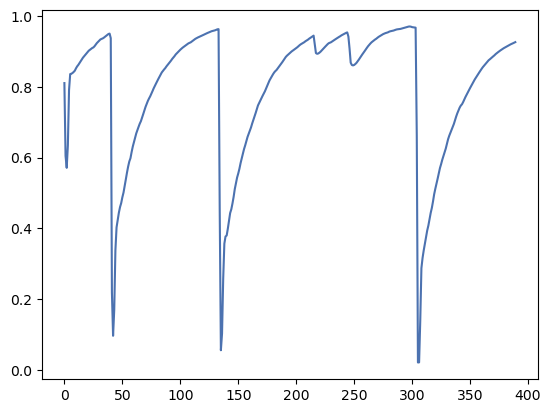

In [14]:
# Plot 3rd X_test window
plt.plot(X_test_sc[:, 2])

## Modelling

In [16]:
import torch.nn as nn


class OneStepLSTM(nn.Module):
    """Subclass of nn.Module"""

    def __init__(
        self, n_variates=1, hidden_size=50, n_layers=1, output_size=FORECAST
    ):
        super().__init__()
        self.n_variates = n_variates
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        # LSTM layer with specified input size, hidden size, and batch_first
        self.lstm = nn.LSTM(
            input_size=self.n_variates,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
        )

        # Linear layer mapping the LSTM output to the forecasted values
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        """Forward pass through the LSTM layer."""
        x, _ = self.lstm(x)
        # Extract the last time step output from the LSTM output
        x = x[:, -1, :]
        # Linear layer for the final output (forecasted values)
        x = self.linear(x)
        return x

### Training

In [17]:
# Move training and testing data to the specified device (cuda or cpu)
X_train_sc = X_train_sc.to(device)
y_train_sc = y_train_sc.to(device)
X_test_sc = X_test_sc.to(device)
y_test_sc = y_test_sc.to(device)

In [18]:
import torch.optim as optim
import torch.utils.data as data

# Define the number of input variates and hidden size
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 2
OUTPUT_SIZE = FORECAST

# Instantiate the OneStepLSTM and move it to the specified device
model = OneStepLSTM(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE).to(device)

# Define Adam optimizer and Mean Squared Error (MSE) loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create a DataLoader for training batches
loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=32
)

# Set the number of training epochs
n_epochs = 200
pbar = tqdm.tqdm(range(n_epochs))

# Lists to store RMSE values for plotting
train_rmse_list = []
test_rmse_list = []

# Training loop
for epoch in pbar:
    model.train()

    # Iterate through batches in the DataLoader
    for X_batch, y_batch in loader:
        # Reshape input for univariate (add a dimension) and model
        y_pred = model(X_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():  # do not consider gradient in evaluating - no backprop
        # Evaluate model on training data
        y_train_pred = model(X_train_sc.unsqueeze(-1))
        y_train_pred = torch.Tensor(
            scaler_y.inverse_transform(y_train_pred.cpu())
        )
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train))
        train_rmse_list.append(train_rmse.item())

        # Evaluate model on testing data
        y_test_pred = model(X_test_sc.unsqueeze(-1))
        y_test_pred = torch.Tensor(
            scaler_y.inverse_transform(y_test_pred.cpu())
        )
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test))
        test_rmse_list.append(test_rmse.item())

    # Update progress bar with training and testing RMSE
    pbar.set_description(
        f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Last Batch Loss: {loss.item():.4f}"
    )

Epoch [200/200], Train RMSE: 0.0161, Test RMSE: 0.0184, Last Batch Loss: 0.0004: 100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


## Results

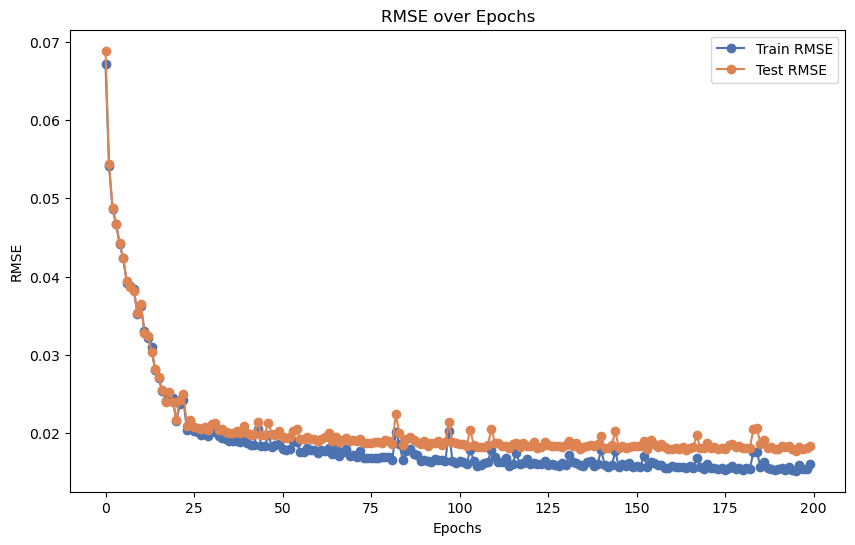

In [19]:
# Plot RMSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_epochs), train_rmse_list, label="Train RMSE", marker="o")
plt.plot(range(0, n_epochs), test_rmse_list, label="Test RMSE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

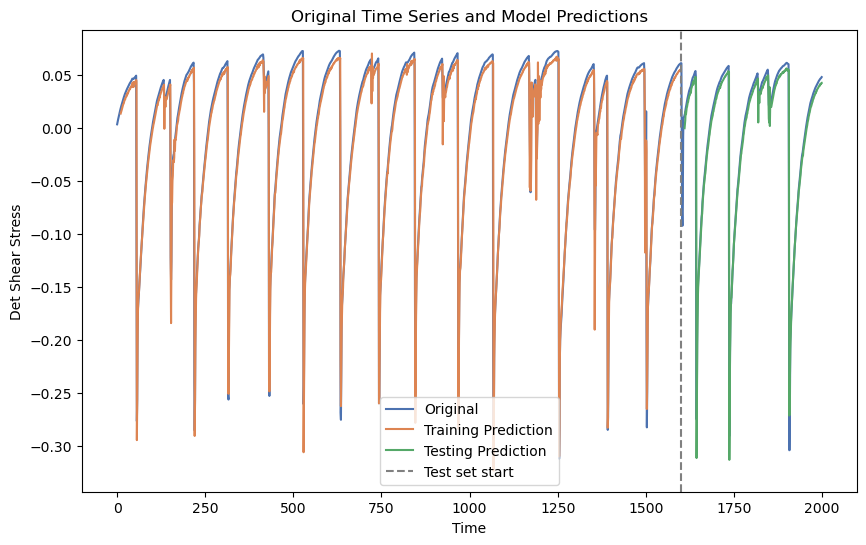

In [20]:
import seaborn as sns

# Set a seaborn color palette for better color choices
sns.set_palette("deep")

with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = [np.nan for x in timeseries]
    # Get predictions for training data and fill the plot array
    train_pred = model(X_train_sc.unsqueeze(-1))
    train_pred = scaler_y.inverse_transform(train_pred.cpu()).reshape(-1)
    train_plot[LOOKBACK : LOOKBACK + len(train_pred)] = train_pred

    # Shift test predictions for plotting
    test_plot = [np.nan for x in timeseries]
    # Get predictions for testing data and fill the plot array
    test_pred = model(X_test_sc.unsqueeze(-1))
    test_pred = scaler_y.inverse_transform(test_pred.cpu()).reshape(-1)
    test_plot[
        2 * LOOKBACK
        + len(train_pred) : 2 * LOOKBACK
        + len(train_pred)
        + len(test_pred)
    ] = test_pred

test_start_index = len(timeseries) - len(y_test) - LOOKBACK

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timeseries.values, label="Original")
plt.plot(train_plot, label="Training Prediction")
plt.plot(test_plot, label="Testing Prediction")
plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.title("Original Time Series and Model Predictions")
plt.xlabel("Time (ms)")
plt.ylabel("Det Shear Stress (MPa)")
plt.legend()
plt.show()